In [81]:
# Setting up
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals import joblib
import seaborn as sns
from sklearn_evaluation import plot as skPlot

# ignore warning 
import warnings
warnings.filterwarnings("ignore")

In [82]:
# Clean data function from Kangwoo's notebook
def clean_data(df):
    data = df[['HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HS', 'AS', 'HST', 'AST']]
    data['HSGR'] = data['FTHG']/data['HS']
    data['ASGR'] = data['FTAG']/data['AS']
    data = data.replace([np.inf, -np.inf], 0)
#     bet_home = df[['B365H','BWH','IWH','PSH','VCH','WHH']].mean(axis=1)
#     bet_draw = df[['B365D','BWD','IWD','PSD','VCD','WHD']].mean(axis=1)
#     bet_away = df[['B365A','BWA','IWA','PSA','VCA','WHA']].mean(axis=1)
    
    
#     data['odd_home'] = bet_home
#     data['odd_draw'] = bet_draw
#     data['odd_away'] = bet_away
    
    data.dropna()
    
    ############### New stuff
    team_scores = {}
    team_shots = {}
    HomeAvgAllTimeSoFar = []
    HomeHighAllTimeSoFar = []
    HomeLowAllTimeSoFar = []
    HomeTotalGoals = []
    HomeTotalShots = []
    HomeTotalAccuracy = []
    AwayAvgAllTimeSoFar = []
    AwayHighAllTimeSoFar = []
    AwayLowAllTimeSoFar = []
    AwayTotalGoals = []
    AwayTotalShots = []
    AwayTotalAccuracy = []
    for index, row in data.iterrows():
        # Add values to all the rows before adding to the team scores
        home_team = row["HomeTeam"]
        away_team = row["AwayTeam"]
        if home_team not in team_scores:
            team_scores[home_team] = []
        if away_team not in team_scores:
            team_scores[away_team] = []
        if home_team not in team_shots:
            team_shots[home_team] = []
        if away_team not in team_shots:
            team_shots[away_team] = []
        home_team_scores = team_scores[home_team]
        away_team_scores = team_scores[away_team]
        home_team_shots = team_shots[home_team]
        away_team_shots = team_shots[away_team]
        if len(home_team_scores) < 1:
            HomeAvgAllTimeSoFar.append(0)
            HomeHighAllTimeSoFar.append(0)
            HomeLowAllTimeSoFar.append(0)
        else: 
            HomeAvgAllTimeSoFar.append(np.mean(home_team_scores))
            HomeHighAllTimeSoFar.append(np.max(home_team_scores).astype("float"))
            HomeLowAllTimeSoFar.append(np.min(home_team_scores).astype("float"))
        if len(away_team_scores) < 1:
            AwayAvgAllTimeSoFar.append(0)
            AwayHighAllTimeSoFar.append(0)
            AwayLowAllTimeSoFar.append(0)
        else: 
            AwayAvgAllTimeSoFar.append(np.mean(away_team_scores))
            AwayHighAllTimeSoFar.append(np.max(away_team_scores).astype("float"))
            AwayLowAllTimeSoFar.append(np.min(away_team_scores).astype("float"))
        s_Home_Scores = np.sum(home_team_scores)
        s_Home_Shots = np.sum(home_team_shots)
        s_Away_Scores = np.sum(away_team_scores)
        s_Away_Shots = np.sum(away_team_shots)
        HomeTotalGoals.append(s_Home_Scores)
        HomeTotalShots.append(s_Home_Shots)
        HomeTotalAccuracy.append(np.nan_to_num(s_Home_Scores/s_Home_Shots))
        AwayTotalGoals.append(s_Away_Scores)
        AwayTotalShots.append(s_Away_Shots)
        AwayTotalAccuracy.append(np.nan_to_num(s_Away_Scores/s_Away_Shots))
        # Add to team scores
        team_scores[home_team].append(row["FTHG"])
        team_scores[away_team].append(row["FTAG"])
        team_shots[home_team].append(row["HS"])
        team_shots[away_team].append(row["AS"])
        
    data["HomeAvgAllTimeSoFar"] = HomeAvgAllTimeSoFar
    data["HomeHighAllTimeSoFar"] = HomeHighAllTimeSoFar
    data["HomeLowAllTimeSoFar"] = HomeLowAllTimeSoFar
    data["AwayAvgAllTimeSoFar"] = AwayAvgAllTimeSoFar
    data["AwayHighAllTimeSoFar"] = AwayHighAllTimeSoFar
    data["AwayLowAllTimeSoFar"] = AwayLowAllTimeSoFar 
    data["HomeTotalGoals"] = HomeTotalGoals
    data["HomeTotalShots"] = HomeTotalShots
    data["HomeTotalAccuracy"] = HomeTotalAccuracy
    data["AwayTotalGoals"] = AwayTotalGoals
    data["AwayTotalShots"] = AwayTotalShots
    data["AwayTotalAccuracy"] = AwayTotalAccuracy
    #####################
    data.dropna()
    data = data.drop(["HomeTeam", "AwayTeam", "FTHG","FTAG","HS","AS","HST","AST","HSGR","ASGR"], axis=1)
    
    return data

In [83]:
# Clean all the data
data_1415 = clean_data(pd.read_csv('./data/1415.csv'))
data_1415.drop(data_1415.tail(1).index,inplace=True)
data_1516 = clean_data(pd.read_csv('./data/1516.csv'))
data_1617 = clean_data(pd.read_csv('./data/1617.csv'))
data_1718 = clean_data(pd.read_csv('./data/1718.csv'))
data_1819 = clean_data(pd.read_csv('./data/1819.csv'))

# 14-15

In [61]:
# create label encoder to convert H, A, or D into factors for who wins (Home, Away, or Draw)
encoder_1415 = LabelEncoder() 
encoder_1415.fit(data_1415["FTR"])
data_1415["FTR"] = encoder_1415.transform(data_1415["FTR"])

# split into training and test data
train_1415, valid_1415, train_labels_1415, valid_labels_1415 = train_test_split(
    data_1415.drop("FTR", axis=1),
    data_1415["FTR"],
    test_size=0.2,
    random_state=123
)

# Model for SVC 1415
svm_model_linear = SVC()
pipe = make_pipeline(svm_model_linear)
param_grid = {
    "svc__kernel": ["linear", "rbf","sigmoid"], # ,"linear", "poly","rbf","sigmoid"
    "svc__degree": [2,3,4] #,3
}
grid_1_1415 = GridSearchCV(pipe, param_grid)
grid_1_1415.fit(train_1415, train_labels_1415)
score1 = grid_1_1415.score(valid_1415, valid_labels_1415)

# Model for MinMaxScaler SVC 1415
scaler=MinMaxScaler()
svm_model_linear = SVC()
pipe = make_pipeline(scaler,svm_model_linear)
param_grid = {
    "svc__kernel": ["linear", "rbf","sigmoid"], # ,"linear", "poly","rbf","sigmoid"
    "svc__degree": [2,3,4] #,3
}
grid_2_1415 = GridSearchCV(pipe, param_grid)
grid_2_1415.fit(train_1415, train_labels_1415)
score2 = grid_2_1415.score(valid_1415, valid_labels_1415)

# Model for MinMaxScaler KNeighborsClassifier 1415
scaler = MinMaxScaler()
knn = KNeighborsClassifier()
pipe = make_pipeline(scaler, knn)
param_grid = {
    "kneighborsclassifier__n_neighbors": range(1,13),
    "kneighborsclassifier__weights": ["uniform", "distance"]
}
grid_3_1415 = GridSearchCV(pipe, param_grid)
grid_3_1415.fit(train_1415, train_labels_1415)
score3 = grid_3_1415.score(valid_1415, valid_labels_1415)

In [63]:
print("SVC 1415:\t\t\t\t", score1)
print("MinMaxScaler SVC 1415:\t\t\t", score2)
print("MinMaxScaler KNeighborsClassifier 1415:\t", score3) 

SVC 1415:				 0.5657894736842105
MinMaxScaler SVC 1415:			 0.5526315789473685
MinMaxScaler KNeighborsClassifier 1415:	 0.5394736842105263


# 15-16

In [64]:
# create label encoder to convert H, A, or D into factors for who wins (Home, Away, or Draw)
encoder_1516 = LabelEncoder() 
encoder_1516.fit(data_1516["FTR"])
data_1516["FTR"] = encoder_1516.transform(data_1516["FTR"])

# split into training and test data
train_1516, valid_1516, train_labels_1516, valid_labels_1516 = train_test_split(
    data_1516.drop("FTR", axis=1),
    data_1516["FTR"],
    test_size=0.2,
    random_state=123
)

# Model for SVC 1516
svm_model_linear = SVC()
pipe = make_pipeline(svm_model_linear)
param_grid = {
    "svc__kernel": ["linear", "rbf","sigmoid"], # ,"linear", "poly","rbf","sigmoid"
    "svc__degree": [2,3,4] #,3
}
grid_1_1516 = GridSearchCV(pipe, param_grid)
grid_1_1516.fit(train_1516, train_labels_1516)
score1 = grid_1_1516.score(valid_1516, valid_labels_1516)

# Model for MinMaxScaler SVC 1516
scaler=MinMaxScaler()
svm_model_linear = SVC()
pipe = make_pipeline(scaler,svm_model_linear)
param_grid = {
    "svc__kernel": ["linear", "rbf","sigmoid"], # ,"linear", "poly","rbf","sigmoid"
    "svc__degree": [2,3,4] #,3
}
grid_2_1516 = GridSearchCV(pipe, param_grid)
grid_2_1516.fit(train_1516, train_labels_1516)
score2 = grid_2_1516.score(valid_1516, valid_labels_1516)

# Model for MinMaxScaler KNeighborsClassifier 1516
scaler = MinMaxScaler()
knn = KNeighborsClassifier()
pipe = make_pipeline(scaler, knn)
param_grid = {
    "kneighborsclassifier__n_neighbors": range(1,13),
    "kneighborsclassifier__weights": ["uniform", "distance"]
}
grid_3_1516 = GridSearchCV(pipe, param_grid)
grid_3_1516.fit(train_1516, train_labels_1516)
score3 = grid_3_1516.score(valid_1516, valid_labels_1516)

In [65]:
print("SVC 1516:\t\t\t\t", score1)
print("MinMaxScaler SVC 1516:\t\t\t", score2)
print("MinMaxScaler KNeighborsClassifier 1516:\t", score3) 

SVC 1516:				 0.4605263157894737
MinMaxScaler SVC 1516:			 0.4473684210526316
MinMaxScaler KNeighborsClassifier 1516:	 0.4342105263157895


# 16-17

In [66]:
# create label encoder to convert H, A, or D into factors for who wins (Home, Away, or Draw)
encoder_1617 = LabelEncoder() 
encoder_1617.fit(data_1617["FTR"])
data_1617["FTR"] = encoder_1617.transform(data_1617["FTR"])

# split into training and test data
train_1617, valid_1617, train_labels_1617, valid_labels_1617 = train_test_split(
    data_1617.drop("FTR", axis=1),
    data_1617["FTR"],
    test_size=0.2,
    random_state=123
)

# Model for SVC 1617
svm_model_linear = SVC()
pipe = make_pipeline(svm_model_linear)
param_grid = {
    "svc__kernel": ["linear", "rbf","sigmoid"], # ,"linear", "poly","rbf","sigmoid"
    "svc__degree": [2,3,4] #,3
}
grid_1_1617 = GridSearchCV(pipe, param_grid)
grid_1_1617.fit(train_1617, train_labels_1617)
score1 = grid_1_1617.score(valid_1617, valid_labels_1617)

# Model for MinMaxScaler SVC 1617
scaler=MinMaxScaler()
svm_model_linear = SVC()
pipe = make_pipeline(scaler,svm_model_linear)
param_grid = {
    "svc__kernel": ["linear", "rbf","sigmoid"], # ,"linear", "poly","rbf","sigmoid"
    "svc__degree": [2,3,4] #,3
}
grid_2_1617 = GridSearchCV(pipe, param_grid)
grid_2_1617.fit(train_1617, train_labels_1617)
score2 = grid_2_1617.score(valid_1617, valid_labels_1617)

# Model for MinMaxScaler KNeighborsClassifier 1617
scaler = MinMaxScaler()
knn = KNeighborsClassifier()
pipe = make_pipeline(scaler, knn)
param_grid = {
    "kneighborsclassifier__n_neighbors": range(1,13),
    "kneighborsclassifier__weights": ["uniform", "distance"]
}
grid_3_1617 = GridSearchCV(pipe, param_grid)
grid_3_1617.fit(train_1617, train_labels_1617)
score3 = grid_3_1617.score(valid_1617, valid_labels_1617)

In [67]:
print("SVC 1617:\t\t\t\t", score1)
print("MinMaxScaler SVC 1617:\t\t\t", score2)
print("MinMaxScaler KNeighborsClassifier 1617:\t", score3) 

SVC 1617:				 0.6447368421052632
MinMaxScaler SVC 1617:			 0.6578947368421053
MinMaxScaler KNeighborsClassifier 1617:	 0.5526315789473685


# 17-18

In [68]:
# create label encoder to convert H, A, or D into factors for who wins (Home, Away, or Draw)
encoder_1718 = LabelEncoder() 
encoder_1718.fit(data_1718["FTR"])
data_1718["FTR"] = encoder_1718.transform(data_1718["FTR"])

# split into training and test data
train_1718, valid_1718, train_labels_1718, valid_labels_1718 = train_test_split(
    data_1718.drop("FTR", axis=1),
    data_1718["FTR"],
    test_size=0.2,
    random_state=123
)

# Model for SVC 1718
svm_model_linear = SVC()
pipe = make_pipeline(svm_model_linear)
param_grid = {
    "svc__kernel": ["linear", "rbf","sigmoid"], # ,"linear", "poly","rbf","sigmoid"
    "svc__degree": [2,3,4] #,3
}
grid_1_1718 = GridSearchCV(pipe, param_grid)
grid_1_1718.fit(train_1718, train_labels_1718)
score1 = grid_1_1718.score(valid_1718, valid_labels_1718)

# Model for MinMaxScaler SVC 1718
scaler=MinMaxScaler()
svm_model_linear = SVC()
pipe = make_pipeline(scaler,svm_model_linear)
param_grid = {
    "svc__kernel": ["linear", "rbf","sigmoid"], # ,"linear", "poly","rbf","sigmoid"
    "svc__degree": [2,3,4] #,3
}
grid_2_1718 = GridSearchCV(pipe, param_grid)
grid_2_1718.fit(train_1718, train_labels_1718)
score2 = grid_2_1718.score(valid_1718, valid_labels_1718)

# Model for MinMaxScaler KNeighborsClassifier 1718
scaler = MinMaxScaler()
knn = KNeighborsClassifier()
pipe = make_pipeline(scaler, knn)
param_grid = {
    "kneighborsclassifier__n_neighbors": range(1,13),
    "kneighborsclassifier__weights": ["uniform", "distance"]
}
grid_3_1718 = GridSearchCV(pipe, param_grid)
grid_3_1718.fit(train_1718, train_labels_1718)
score3 = grid_3_1718.score(valid_1718, valid_labels_1718)

In [69]:
print("SVC 1718:\t\t\t\t", score1)
print("MinMaxScaler SVC 1718:\t\t\t", score2)
print("MinMaxScaler KNeighborsClassifier 1718:\t", score3) 

SVC 1718:				 0.5394736842105263
MinMaxScaler SVC 1718:			 0.5
MinMaxScaler KNeighborsClassifier 1718:	 0.4605263157894737


# 18-19

In [70]:
# create label encoder to convert H, A, or D into factors for who wins (Home, Away, or Draw)
encoder_1819 = LabelEncoder() 
encoder_1819.fit(data_1819["FTR"])
data_1819["FTR"] = encoder_1819.transform(data_1819["FTR"])

# split into training and test data
train_1819, valid_1819, train_labels_1819, valid_labels_1819 = train_test_split(
    data_1819.drop("FTR", axis=1),
    data_1819["FTR"],
    test_size=0.2,
    random_state=123
)

# Model for SVC 1819
svm_model_linear = SVC()
pipe = make_pipeline(svm_model_linear)
param_grid = {
    "svc__kernel": ["linear", "rbf","sigmoid"], # ,"linear", "poly","rbf","sigmoid"
    "svc__degree": [2,3,4] #,3
}
grid_1_1819 = GridSearchCV(pipe, param_grid)
grid_1_1819.fit(train_1819, train_labels_1819)
score1 = grid_1_1819.score(valid_1819, valid_labels_1819)

# Model for MinMaxScaler SVC 1819
scaler=MinMaxScaler()
svm_model_linear = SVC()
pipe = make_pipeline(scaler,svm_model_linear)
param_grid = {
    "svc__kernel": ["linear", "rbf","sigmoid"], # ,"linear", "poly","rbf","sigmoid"
    "svc__degree": [2,3,4] #,3
}
grid_2_1819 = GridSearchCV(pipe, param_grid)
grid_2_1819.fit(train_1819, train_labels_1819)
score2 = grid_2_1819.score(valid_1819, valid_labels_1819)

# Model for MinMaxScaler KNeighborsClassifier 1819
scaler = MinMaxScaler()
knn = KNeighborsClassifier()
pipe = make_pipeline(scaler, knn)
param_grid = {
    "kneighborsclassifier__n_neighbors": range(1,13),
    "kneighborsclassifier__weights": ["uniform", "distance"]
}
grid_3_1819 = GridSearchCV(pipe, param_grid)
grid_3_1819.fit(train_1819, train_labels_1819)
score3 = grid_3_1819.score(valid_1819, valid_labels_1819)

In [71]:
print("SVC 1819:\t\t\t\t", score1)
print("MinMaxScaler SVC 1819:\t\t\t", score2)
print("MinMaxScaler KNeighborsClassifier 1819:\t", score3) 

SVC 1819:				 0.603448275862069
MinMaxScaler SVC 1819:			 0.6551724137931034
MinMaxScaler KNeighborsClassifier 1819:	 0.5344827586206896


# All

In [111]:
# concatenate all data
data_all_data = pd.concat([data_1415, data_1516, data_1617, data_1718, data_1819], axis=0, ignore_index=True)

In [73]:
# create label encoder to convert H, A, or D into factors for who wins (Home, Away, or Draw)
encoder_all_data = LabelEncoder() 
encoder_all_data.fit(data_all_data["FTR"])
data_all_data["FTR"] = encoder_all_data.transform(data_all_data["FTR"])

# split into training and test data
train_all_data, valid_all_data, train_labels_all_data, valid_labels_all_data = train_test_split(
    data_all_data.drop("FTR", axis=1),
    data_all_data["FTR"],
    test_size=0.2,
    random_state=123
)

# Model for SVC all_data
svm_model_linear = SVC()
pipe = make_pipeline(svm_model_linear)
param_grid = {
    "svc__kernel": ["linear", "rbf","sigmoid"], # ,"linear", "poly","rbf","sigmoid"
    "svc__degree": [2,3,4] #,3
}
grid_1_all_data = GridSearchCV(pipe, param_grid)
grid_1_all_data.fit(train_all_data, train_labels_all_data)
score1 = grid_1_all_data.score(valid_all_data, valid_labels_all_data)

# Model for MinMaxScaler SVC all_data
scaler=MinMaxScaler()
svm_model_linear = SVC()
pipe = make_pipeline(scaler,svm_model_linear)
param_grid = {
    "svc__kernel": ["linear", "rbf","sigmoid"], # ,"linear", "poly","rbf","sigmoid"
    "svc__degree": [2,3,4] #,3
}
grid_2_all_data = GridSearchCV(pipe, param_grid)
grid_2_all_data.fit(train_all_data, train_labels_all_data)
score2 = grid_2_all_data.score(valid_all_data, valid_labels_all_data)

# Model for MinMaxScaler KNeighborsClassifier all_data
scaler = MinMaxScaler()
knn = KNeighborsClassifier()
pipe = make_pipeline(scaler, knn)
param_grid = {
    "kneighborsclassifier__n_neighbors": range(1,13),
    "kneighborsclassifier__weights": ["uniform", "distance"]
}
grid_3_all_data = GridSearchCV(pipe, param_grid)
grid_3_all_data.fit(train_all_data, train_labels_all_data)
score3 = grid_3_all_data.score(valid_all_data, valid_labels_all_data)

In [77]:
print("SVC all_data:\t\t\t\t\t", score1)
print("MinMaxScaler SVC all_data:\t\t\t", score2)
print("MinMaxScaler KNeighborsClassifier all_data:\t", score3) 

SVC all_data:					 0.505524861878453
MinMaxScaler SVC all_data:			 0.5138121546961326
MinMaxScaler KNeighborsClassifier all_data:	 0.47790055248618785


In [84]:
# Export all grids to files to access later on to not have to re-train everything
grids = {
    "grid_1_1415": grid_1_1415,
    "grid_2_1415": grid_2_1415,
    "grid_3_1415": grid_3_1415,
    "grid_1_1516": grid_1_1516,
    "grid_2_1516": grid_2_1516,
    "grid_3_1516": grid_3_1516,
    "grid_1_1617": grid_1_1617,
    "grid_2_1617": grid_2_1617,
    "grid_3_1617": grid_3_1617,
    "grid_1_1718": grid_1_1718,
    "grid_2_1718": grid_2_1718,
    "grid_3_1718": grid_3_1718,
    "grid_1_1819": grid_1_1819,
    "grid_2_1819": grid_2_1819,
    "grid_3_1819": grid_3_1819,
    "grid_1_all_data": grid_1_all_data,
    "grid_2_all_data": grid_2_all_data,
    "grid_3_all_data": grid_3_all_data,
}

for gridfinal in grids:
    m = grids[gridfinal]
    joblib.dump(m, "grid_dump/" + gridfinal + ".pkl")

In [85]:
# Load in all grids from the grid dump
grid_1_1415 = joblib.load("grid_dump/grid_1_1415.pkl")
grid_2_1415 = joblib.load("grid_dump/grid_2_1415.pkl")
grid_3_1415 = joblib.load("grid_dump/grid_3_1415.pkl")
grid_1_1516 = joblib.load("grid_dump/grid_1_1516.pkl")
grid_2_1516 = joblib.load("grid_dump/grid_2_1516.pkl")
grid_3_1516 = joblib.load("grid_dump/grid_3_1516.pkl")
grid_1_1617 = joblib.load("grid_dump/grid_1_1617.pkl")
grid_2_1617 = joblib.load("grid_dump/grid_2_1617.pkl")
grid_3_1617 = joblib.load("grid_dump/grid_3_1617.pkl")
grid_1_1718 = joblib.load("grid_dump/grid_1_1718.pkl")
grid_2_1718 = joblib.load("grid_dump/grid_2_1718.pkl")
grid_3_1718 = joblib.load("grid_dump/grid_3_1718.pkl")
grid_1_1819 = joblib.load("grid_dump/grid_1_1819.pkl")
grid_2_1819 = joblib.load("grid_dump/grid_2_1819.pkl")
grid_3_1819 = joblib.load("grid_dump/grid_3_1819.pkl")
grid_1_all_data = joblib.load("grid_dump/grid_1_all_data.pkl")
grid_2_all_data = joblib.load("grid_dump/grid_2_all_data.pkl")
grid_3_all_data = joblib.load("grid_dump/grid_3_all_data.pkl")

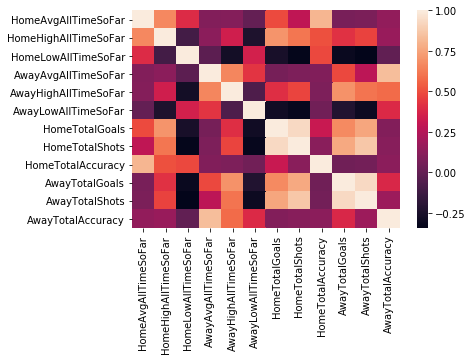

In [47]:
# Show correlation between all variables in data_all
corr = data_all_data.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)
plt.show()

In [113]:
dftr = data_1415["FTR"]
dftrH = data_1415[data_1415["FTR"] == "H"]
dftrD = data_1415[data_1415["FTR"] == "D"]
dftrA = data_1415[data_1415["FTR"] == "A"]
print("1415", (len(dftr), len(dftrH), len(dftrD), len(dftrA)), len(dftrH)/len(dftr))

dftr = data_1516["FTR"]
dftrH = data_1516[data_1516["FTR"] == "H"]
dftrD = data_1516[data_1516["FTR"] == "D"]
dftrA = data_1516[data_1516["FTR"] == "A"]
print("1516", (len(dftr), len(dftrH), len(dftrD), len(dftrA)), len(dftrH)/len(dftr))

dftr = data_1617["FTR"]
dftrH = data_1617[data_1617["FTR"] == "H"]
dftrD = data_1617[data_1617["FTR"] == "D"]
dftrA = data_1617[data_1617["FTR"] == "A"]
print("1617", (len(dftr), len(dftrH), len(dftrD), len(dftrA)), len(dftrH)/len(dftr))

dftr = data_1718["FTR"]
dftrH = data_1718[data_1718["FTR"] == "H"]
dftrD = data_1718[data_1718["FTR"] == "D"]
dftrA = data_1718[data_1718["FTR"] == "A"]
print("1718", (len(dftr), len(dftrH), len(dftrD), len(dftrA)), len(dftrH)/len(dftr))

dftr = data_1819["FTR"]
dftrH = data_1819[data_1819["FTR"] == "H"]
dftrD = data_1819[data_1819["FTR"] == "D"]
dftrA = data_1819[data_1819["FTR"] == "A"]
print("1819", (len(dftr), len(dftrH), len(dftrD), len(dftrA)), len(dftrH)/len(dftr))

dftr = data_all_data["FTR"]
dftrH = data_all_data[data_all_data["FTR"] == "H"]
dftrD = data_all_data[data_all_data["FTR"] == "D"]
dftrA = data_all_data[data_all_data["FTR"] == "A"]
print("all_data", (len(dftr), len(dftrH), len(dftrD), len(dftrA)), len(dftrH)/len(dftr))

1415 (380, 172, 93, 115) 0.45263157894736844
1516 (380, 157, 107, 116) 0.4131578947368421
1617 (380, 187, 84, 109) 0.4921052631578947
1718 (380, 173, 99, 108) 0.45526315789473687
1819 (289, 137, 56, 96) 0.4740484429065744
all_data (1809, 826, 439, 544) 0.4566058595909342


# Model accuracies
| Model                                      | Accuracy            |
| ------------------------------------------ | ------------------- |
| SVC 1415                                   | 0.5657894736842105  |
| MinMaxScaler SVC 1415                      | 0.5526315789473685  |
| MinMaxScaler KNeighborsClassifier 1415     | 0.5394736842105263  |
| --- | --- |
| SVC 1516                                   | 0.4605263157894737  |
| MinMaxScaler SVC 1516                      | 0.4473684210526316  |
| MinMaxScaler KNeighborsClassifier 1516     | 0.4342105263157895  |
| --- | --- |
| SVC 1617                                   | 0.6447368421052632  |
| MinMaxScaler SVC 1617                      | 0.6578947368421053  |
| MinMaxScaler KNeighborsClassifier 1617     | 0.5526315789473685  |
| --- | --- |
| SVC 1718                                   | 0.5394736842105263  |
| MinMaxScaler SVC 1718                      | 0.5                 |
| MinMaxScaler KNeighborsClassifier 1718     | 0.4605263157894737  |
| --- | --- |
| SVC 1819                                   | 0.603448275862069   |
| MinMaxScaler SVC 1819                      | 0.6551724137931034  |
| MinMaxScaler KNeighborsClassifier 1819     | 0.5344827586206896  |
| --- | --- |
| SVC all_data                               | 0.505524861878453   |
| MinMaxScaler SVC all_data                  | 0.5138121546961326  |
| MinMaxScaler KNeighborsClassifier all_data | 0.47790055248618785 |


# Using Poisson

We attempted to run a poisson model on the data to produce a guess for if the Home team would win, Away team, or if it would end up in a draw. We encoded the values using `sklearn`'s `LabelEncoder` function. Then we split the data into test and training data. We then plugged it into a general linear model with a Poisson family using the following formulas: `FTR ~ HomeTeam + AwayTeam`, `FTR ~ HomeTeam + AwayTeam + HomeAvgAllTimeSoFar + HomeHighAllTimeSoFar + HomeLowAllTimeSoFar + AwayAvgAllTimeSoFar + AwayHighAllTimeSoFar + AwayLowAllTimeSoFar + HomeTotalGoals + HomeTotalShots + HomeTotalAccuracy + AwayTotalGoals + AwayTotalShots + AwayTotalAccuracy`, and `FTR ~ + HomeHighAllTimeSoFar + HomeLowAllTimeSoFar + AwayAvgAllTimeSoFar + AwayHighAllTimeSoFar + AwayLowAllTimeSoFar + HomeTotalGoals + HomeTotalShots + HomeTotalAccuracy + AwayTotalGoals + AwayTotalShots + AwayTotalAccuracy`.

Here are a list of the values we used in these models:
* `HomeTeam` - Name of the home team
* `AwayTeam` - Name of the away team
* `HomeAvgAllTimeSoFar` - Average of all scores from each game the home team has played by that point in time.
* `HomeHighAllTimeSoFar` - Highest of all scores from each game the home team has played by that point in time.
* `HomeLowAllTimeSoFar` - Lowest of all scores from each game the home team has played by that point in time.
* `AwayAvgAllTimeSoFar` - Average of all scores from each game the away team has played by that point in time.
* `AwayHighAllTimeSoFar` - Highest of all scores from each game the away team has played by that point in time.
* `AwayLowAllTimeSoFar` - Lowest of all scores from each game the away team has played by that point in time.
* `HomeTotalGoals` - Total home goals to date
* `HomeTotalShots` - Total home shots to date
* `HomeTotalAccuracy` - Home accuracy to date
* `AwayTotalGoals` - Total away goals to date
* `AwayTotalShots` - Total away shots to date
* `AwayTotalAccuracy` - Away accuracy to date

## For each year

First we ran this model on the separate datasets. At first, we tried out just the Home team and Away team names as factors in the model, similar (but not exactly!) to [David Sheehan's study](https://dashee87.github.io/football/python/predicting-football-results-with-statistical-modelling/). We received these accuracy scores.

* 14-15: 0.368
* 15-16: 0.329
* 16-17: 0.395
* 17-18: 0.382
* 18-19: 0.431

This very simple model seems to be able to guess it more than a third of the time mostly. However, that isn't as good as we would like. It is just slightly better than guessing at random. In 2015-2016, it would have been _worse_ than guessing at random. 

We then tried with only the factors we generated and found a dip in performance for most of the years.

* 14-15: 0.289
* 15-16: 0.289
* 16-17: 0.355
* 17-18: 0.382
* 18-19: 0.362

Finally, we tried both the home team and away team names as factors combined with our factors, and we saw a slight improvement in most of the scores.

* 14-15: 0.368
* 15-16: 0.382
* 16-17: 0.408
* 17-18: 0.395
* 18-19: 0.362

We theorize that 18-19 is so low accuracy because there haven't been as many games played thus far. 

## Combined

We also ran the model on all the combined datasets. Note that while combined, the "All Time" factors are localized to the season the data point came from, meaning there are no "lifetime" data points besides the name of the team (doing so doesn't provide any increase in accuracy). For the model that just had team names as factors, we received an accuracy of 0.387. For the model with just our factors, we received an accuracy of 0.362. For the model with those combined, we received an accuracy of 0.398. 

If we take a look at the summary of the model with the team names as factors alongside our factors, we see that some of the factors are significant. To contrast [David Sheehan's study](https://dashee87.github.io/football/python/predicting-football-results-with-statistical-modelling/), we didn't receive as many significant p values because we did not combine `HomeTeam` and `AwayTeam` into a single `team` variable for this specific analysis. 

In [268]:
m1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    FTR   No. Observations:                 1447
Model:                            GLM   Df Residuals:                     1378
Model Family:                 Poisson   Df Model:                           68
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1782.6
Date:                Tue, 12 Mar 2019   Deviance:                       1145.1
Time:                        21:24:07   Pearson chi2:                     865.
No. Iterations:                     5   Covariance Type:             nonrobust
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.2067      0.216      0.956      0.339      -0.217       0.630
HomeTeam[T.Aston Villa]       -0.8236      0.267     -3.083      0.002      -1.347      -0.300
HomeTeam[T.Bournemouth]       -0.3208      0.171     -1.879      0.060      -0.655       0.014
HomeTeam[T.Brighton]          -0.1526      0.217     -0.704      0.482      -0.578       0.273
HomeTeam[T.Burnley]           -0.3196      0.189     -1.692      0.091      -0.690       0.051
HomeTeam[T.Cardiff]           -0.6427      0.344     -1.870      0.061      -1.316       0.031
HomeTeam[T.Chelsea]           -0.0966      0.133     -0.725      0.468      -0.358       0.165
HomeTeam[T.Crystal Palace]    -0.5529      0.171     -3.232      0.001      -0.888      -0.218
HomeTeam[T.Everton]           -0.2673      0.152     -1.762      0.078      -0.565       0.030
HomeTeam[T.Fulham]            -0.7869      0.398     -1.977      0.048      -1.567      -0.007
HomeTeam[T.Huddersfield]      -0.6784      0.278     -2.440      0.015      -1.223      -0.133
HomeTeam[T.Hull]              -0.4553      0.221     -2.061      0.039      -0.888      -0.022
HomeTeam[T.Leicester]         -0.2157      0.155     -1.391      0.164      -0.520       0.088
HomeTeam[T.Liverpool]         -0.1082      0.135     -0.800      0.424      -0.373       0.157
HomeTeam[T.Man City]          -0.0918      0.142     -0.647      0.518      -0.370       0.186
HomeTeam[T.Man United]        -0.0234      0.135     -0.174      0.862      -0.288       0.241
HomeTeam[T.Middlesbrough]     -0.4627      0.311     -1.487      0.137      -1.073       0.147
HomeTeam[T.Newcastle]         -0.3958      0.180     -2.199      0.028      -0.749      -0.043
HomeTeam[T.Norwich]           -0.6440      0.323     -1.996      0.046      -1.276      -0.012
HomeTeam[T.QPR]               -0.4678      0.284     -1.646      0.100      -1.025       0.089
HomeTeam[T.Southampton]       -0.3345      0.155     -2.163      0.031      -0.638      -0.031
HomeTeam[T.Stoke]             -0.3278      0.171     -1.914      0.056      -0.664       0.008
HomeTeam[T.Sunderland]        -0.6836      0.218     -3.132      0.002      -1.111      -0.256
HomeTeam[T.Swansea]           -0.4001      0.182     -2.196      0.028      -0.757      -0.043
HomeTeam[T.Tottenham]         -0.1366      0.137     -0.997      0.319      -0.405       0.132
HomeTeam[T.Watford]           -0.2621      0.171     -1.529      0.126      -0.598       0.074
HomeTeam[T.West Brom]         -0.5356      0.186     -2.887      0.004      -0.899      -0.172
HomeTeam[T.West Ham]          -0.3562      0.157     -2.274      0.023      -0.663      -0.049
HomeTeam[T.Wolves]            -0.2620      0.301     -0.871      0.384      -0.851       0.328
AwayTeam[T.Aston Villa]        0.3467      0.219      1.581      0.114      -0.083       0.776
AwayTeam[T.Bournemouth]    

If we view a summary of the model with our created factors, we see that `HomeAvgAllTimeSoFar`, `AwayAvgAllTimeSoFar`, and `AwayTotalAccuracy` contribute the most to the prediction of the outcome of the game with greater than 95% certainty. 


In [269]:
m2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    FTR   No. Observations:                 1447
Model:                            GLM   Df Residuals:                     1434
Model Family:                 Poisson   Df Model:                           12
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1818.3
Date:                Tue, 12 Mar 2019   Deviance:                       1216.6
Time:                        21:27:49   Pearson chi2:                     896.
No. Iterations:                     5   Covariance Type:             nonrobust
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.0160      0.122     -0.131      0.896      -0.255       0.223
HomeAvgAllTimeSoFar      0.3790      0.114      3.314      0.001       0.155       0.603
HomeHighAllTimeSoFar     0.0088      0.031      0.282      0.778      -0.052       0.070
HomeLowAllTimeSoFar     -0.1273      0.093     -1.363      0.173      -0.310       0.056
AwayAvgAllTimeSoFar     -0.4953      0.134     -3.688      0.000      -0.759      -0.232
AwayHighAllTimeSoFar     0.0206      0.030      0.690      0.490      -0.038       0.079
AwayLowAllTimeSoFar      0.0202      0.107      0.188      0.851      -0.190       0.230
HomeTotalGoals          -0.0016      0.006     -0.274      0.784      -0.013       0.010
HomeTotalShots           0.0011      0.001      1.368      0.171      -0.000       0.003
HomeTotalAccuracy       -1.6430      1.321     -1.244      0.213      -4.231       0.946
AwayTotalGoals          -0.0033      0.006     -0.516      0.606      -0.016       0.009
AwayTotalShots          -0.0007      0.001     -0.864      0.387      -0.002       0.001
AwayTotalAccuracy        3.6994      1.458      2.537      0.011       0.842       6.557
========================================================================================
"""